# merging modis granules

In [1]:
import rioxarray
import rioxarray.merge as riomerge
import xarray
from pathlib import Path
import cartopy.crs as ccrs
import cartopy
from matplotlib import pyplot as plt
import numpy as np

## open the images

The default nasa projection is a [custom sinusoidal grid](https://pro.arcgis.com/en/pro-app/3.1/help/mapping/properties/sinusoidal.htm#:~:text=Sinusoidal%20is%20a%20pseudocylindric%20projection,central%20meridian%20and%20equally%20spaced.)

In [2]:
images = (Path.home() / "repos/a448_2024/data").glob("*tif")
images = list(images)
image1, image2 = images
rio_image1 = rioxarray.open_rasterio(image1, mask_and_scale = True)
rio_image2 = rioxarray.open_rasterio(image2, mask_and_scale = True)
wkt_text = rio_image1.spatial_ref.crs_wkt
wkt_text

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [3]:
rio_image1.rio.transform()

Affine(926.6254331391661, 0.0, -10007554.677899,
       0.0, -926.625433139167, 5559752.598833)

In [4]:
rio_image2.rio.transform()

Affine(926.6254331383334, 0.0, -8895604.158132,
       0.0, -926.625433139167, 5559752.598833)

In [5]:
rio_image1.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes: (12/16)
    crs_wkt:                         PROJCS["unnamed",GEOGCS["Unknown datum b...
    semi_major_axis:                 6371007.181
    semi_minor_axis:                 6371007.181
    inverse_flattening:              0.0
    reference_ellipsoid_name:        Custom spheroid
    longitude_of_prime_meridian:     0.0
    ...                              ...
    grid_mapping_name:               sinusoidal
    longitude_of_projection_origin:  0.0
    false_easting:                   0.0
    false_northing:                  0.0
    spatial_ref:                     PROJCS["unnamed",GEOGCS["Unknown datum b...
    GeoTransform:                    -10007554.677899 926.6254331391661 0.0 5...

## squeeze out the band dimension

In [6]:
rio_image1.shape, rio_image2.shape

((1, 1200, 1200), (1, 1200, 1200))

[test](https://spatialreference.org/ref/epsg/3157)

In [7]:
image1 = rio_image1.squeeze()
image2 = rio_image2.squeeze()

## reproject onto UTM Zone 10N

Reference [EPSG:3157](https://spatialreference.org/ref/epsg/3157)  -- keep resolution at 926 meters

In [8]:
code = "EPSG:3157"
image1 = image1.rio.reproject(code,resolution=926)
image2 = image2.rio.reproject(code,resolution=926)
image1.spatial_ref.crs_wkt

'PROJCS["NAD83(CSRS) / UTM zone 10N",GEOGCS["NAD83(CSRS)",DATUM["NAD83_Canadian_Spatial_Reference_System",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6140"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4617"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3157"]]'

## Plot images with cartopy

In [9]:
code = "3157"
projection = ccrs.epsg(code)
geodetic = ccrs.Geodetic()

In [10]:
image1.rio.transform(), image2.rio.transform()

(Affine(926.0, 0.0, -716077.9493052305,
        0.0, -926.0, 5678843.194819922),
 Affine(926.0, 0.0, 395518.0762863428,
        0.0, -926.0, 5634582.799151534))

bounds are

In [11]:
image1.rio.bounds(), image2.rio.bounds()

((-716077.9493052305,
  4441707.194819922,
  2089702.0506947695,
  5678843.194819922),
 (395518.0762863428, 4595610.799151534, 3217966.076286343, 5634582.799151534))

## Get the coordinates for the bounding box

The upper left coordinates are 49.35N and 123.26W, and the lower right coordinates are 49.00N and 122.50W.

In [12]:
ul_lat, ul_lon = (49.35, -123.26)
lr_lat, lr_lon = (49, -122.50)
#ul_lat, ul_lon = (50, -126)
#lr_lat, lr_lon = (40, -121)
ul_x, ul_y  = projection.transform_point(ul_lon,ul_lat,geodetic)
lr_x, lr_y = projection.transform_point(lr_lon, lr_lat, geodetic)
extent = (ul_x,lr_x,ul_y,lr_y)
extent         

(481117.6785458467, 536572.314722576, 5466396.67943242, 5427575.583354357)

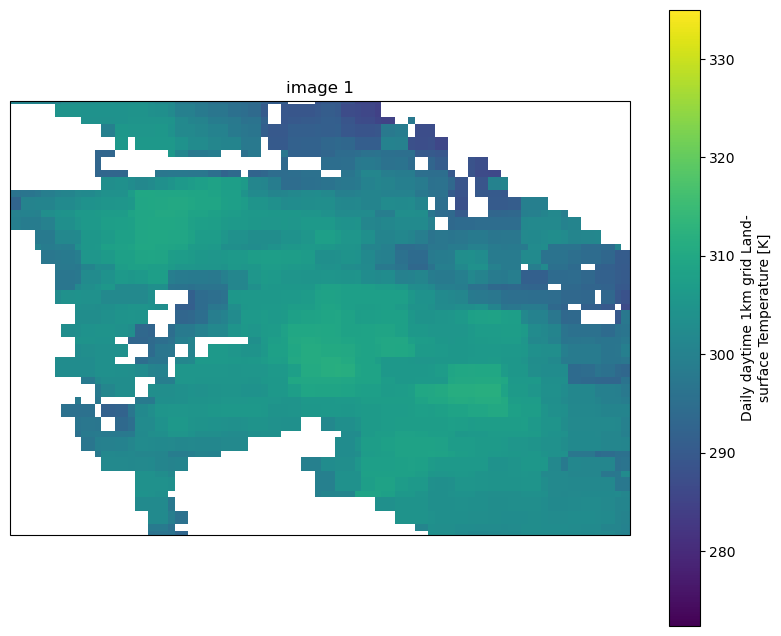

In [13]:
kw_dict = dict(projection=projection)
fig, ax1 = plt.subplots(1,1,figsize=(10,8),subplot_kw = kw_dict)
image1.plot.imshow(ax=ax1,origin="upper")
ax1.set_extent(extent, crs = projection)
ax1.set_title('image 1');

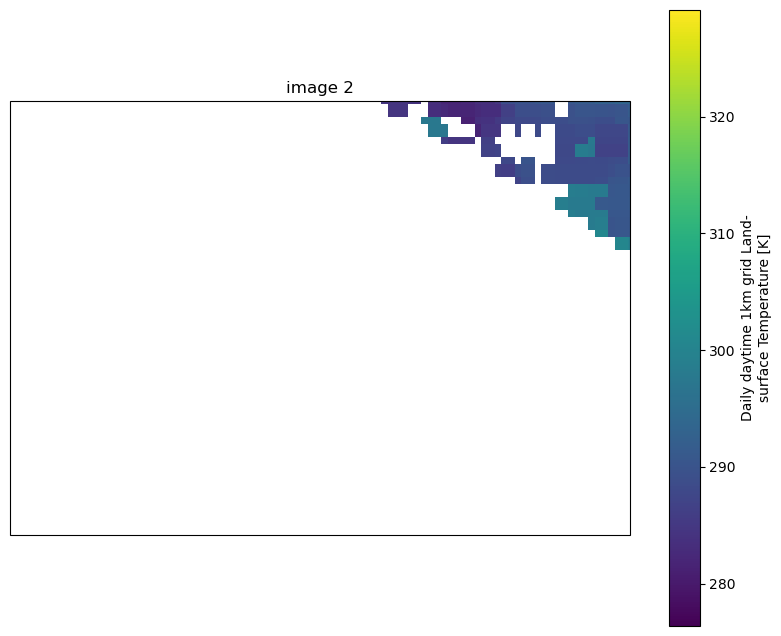

In [14]:
fig, ax2 = plt.subplots(1,1,figsize=(10,8),subplot_kw = kw_dict)
image2.plot.imshow(ax=ax2)
ax2.set_extent(extent, crs = projection)
ax2.set_title('image 2');

## find ul and lr corners of image 1

Use the [affine transform](https://www.perrygeo.com/python-affine-transforms.html) to find the
row, column in the image1 array that correspont to the ul and lr corners

In [15]:
image1.shape, image2.shape

((1336, 3030), (1122, 3048))

## find the ul column, row

In [16]:
ul_col, ul_row = ~image1.rio.transform()*(ul_x,ul_y)
ul_col,ul_row = int(np.round(ul_col)), int(np.round(ul_row))
ul_col,ul_row

(1293, 229)

## find the lr column, row

In [17]:
lr_col, lr_row = ~image1.rio.transform()*(lr_x, lr_y)
lr_col,lr_row = int(np.round(lr_col)), int(np.round(lr_row))
lr_col, lr_row

(1353, 271)

## slice the array between those rows and columns

In [18]:
image1 = image1[ul_row:lr_row,ul_col:lr_col]
print(f"{image1.shape=}")

image1.shape=(42, 60)


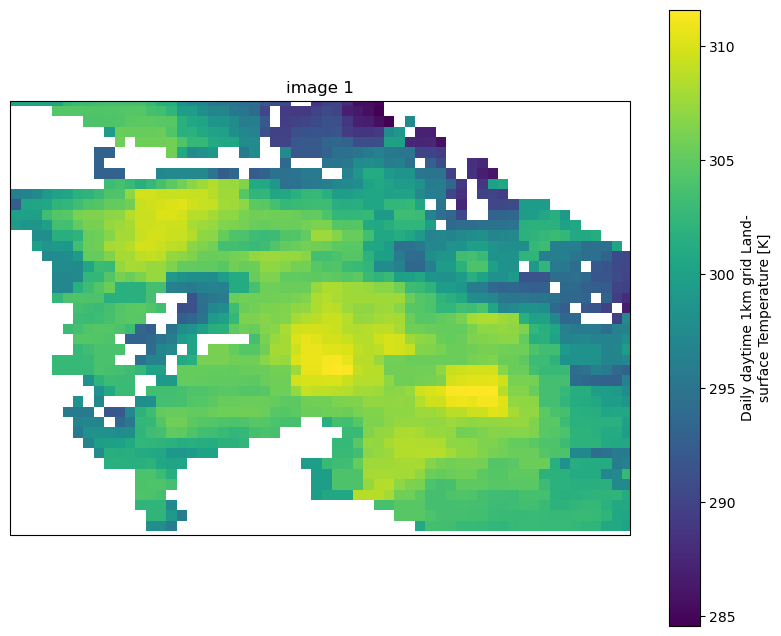

In [19]:
fig, ax2 = plt.subplots(1,1,figsize=(10,8),subplot_kw = kw_dict)
image1.plot.imshow(ax=ax2)
ax2.set_extent(extent, crs = projection)
ax2.set_title('image 1');

## now do the same for image 2

In [20]:
ul_col, ul_row = ~image2.rio.transform()*(ul_x,ul_y)
ul_col,ul_row = int(np.round(ul_col)), int(np.round(ul_row))
ul_col,ul_row

(92, 182)

In [21]:
lr_col, lr_row = ~image2.rio.transform()*(lr_x, lr_y)
lr_col,lr_row = int(np.round(lr_col)), int(np.round(lr_row))
lr_col, lr_row

(152, 224)

In [22]:
image2 = image2[ul_row:lr_row,ul_col:lr_col]
print(f"{image2.shape=}")

image2.shape=(42, 60)


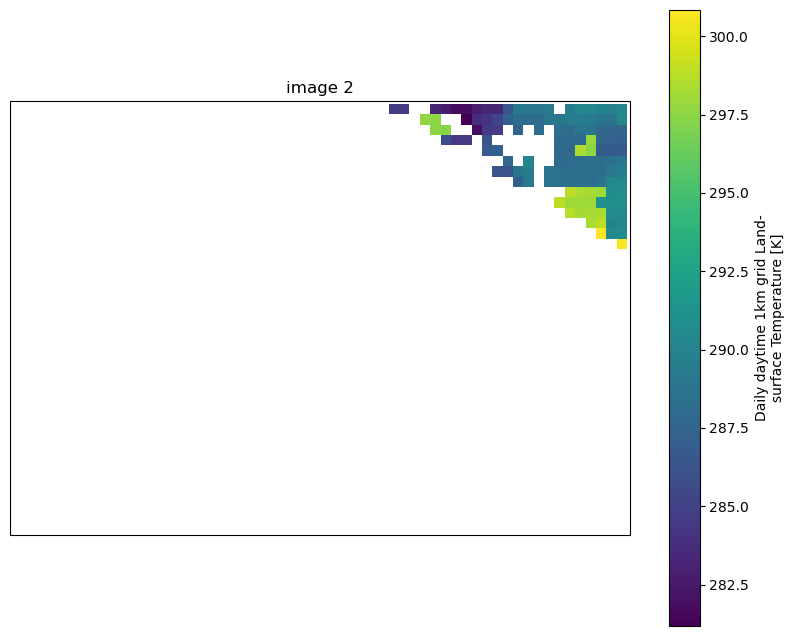

In [23]:
fig, ax2 = plt.subplots(1,1,figsize=(10,8),subplot_kw = kw_dict)
image2.plot.imshow(ax=ax2)
ax2.set_extent(extent, crs = projection)
ax2.set_title('image 2');

## now combine the images

Set the nans to zeros so you can add the images together, then set
the remaining zeros back to nans

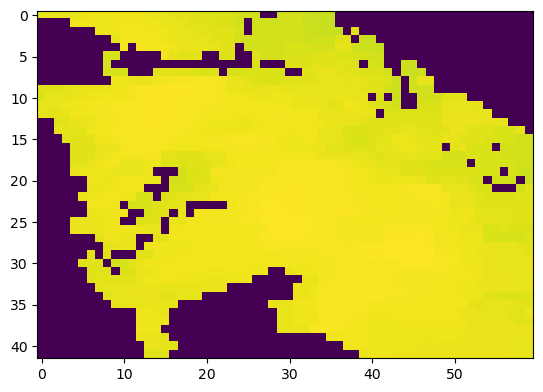

In [24]:
data1 = np.nan_to_num(image1,nan=0)
plt.imshow(data1);

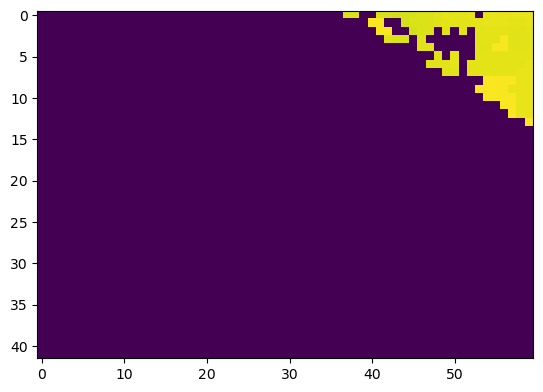

In [25]:
data2 = np.nan_to_num(image2,nan=0)
plt.imshow(data2);

In [26]:
combined = data1[:,:] + data2[:,:]

In [27]:
final_image = np.where(combined==0, np.nan, combined)

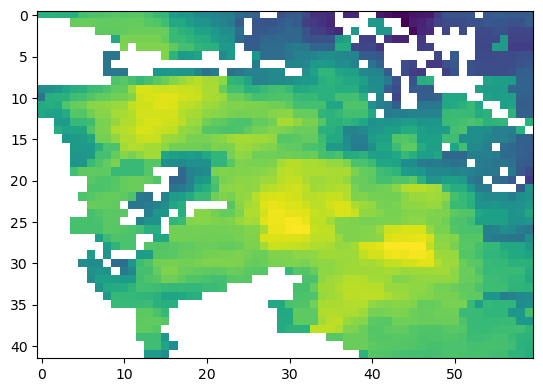

In [28]:
plt.imshow(final_image);